In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Django', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 20579.90 seconds 
duration: 5.72 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 15.9 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


start        stop label  duration
0    729.2412    729.9500  None    0.7088
1   1097.3612   1099.2852  None    1.9240
2   1382.4284   1383.8692  None    1.4408
3   1672.6000   1674.1000  None    1.5000
4   1952.6188   1954.1436  None    1.5248
5   2220.3684   2221.7436  None    1.3752
6   2499.3000   2500.7500  None    1.4500
7   9356.3572   9361.7388  None    5.3816
8  15761.5868  15762.1756  None    0.5888

<Axes: >

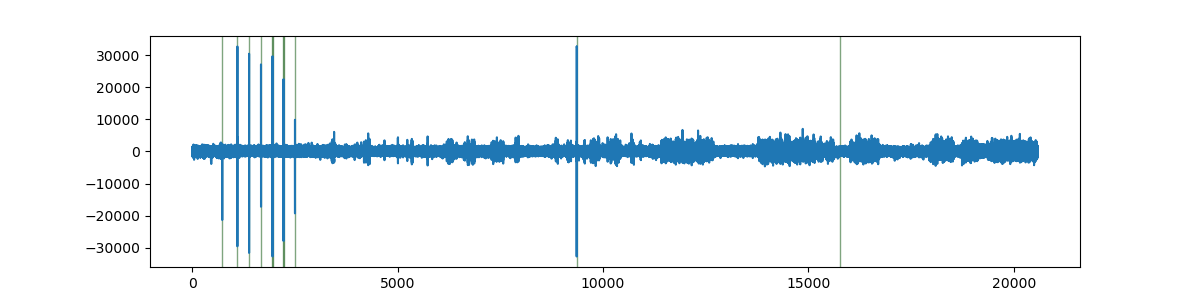

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.probegroup.npy saved


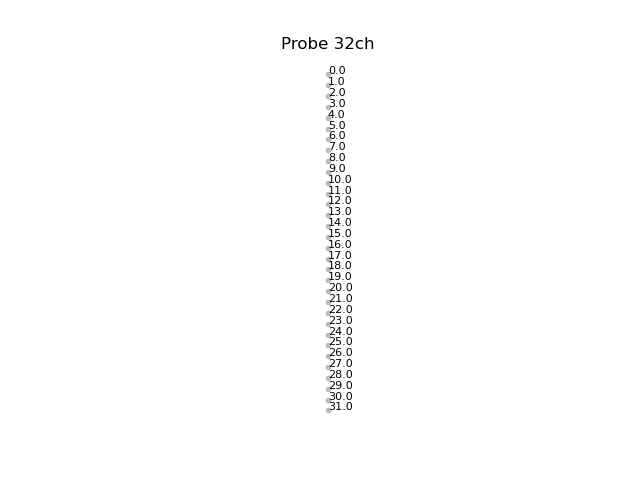

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Delta

In [8]:
# Delta
from neuropy.analyses.oscillations import detect_hpc_delta_wave_epochs
min_dur = 0.15  
max_dur = 0.5   
ignore_epochs = None  
delta_channel = 59

freq_band = (0.5, 4)

if delta_channel is not None:
    signal_use = signal.time_slice(channel_id=delta_channel)
else:
    signal_use = signal

delta_epochs = detect_hpc_delta_wave_epochs(
    signal_use, freq_band=freq_band, min_dur=min_dur, max_dur=max_dur, ignore_epochs=ignore_epochs
)
sess.recinfo.write_epochs(delta_epochs, ext='dta')
delta_epochs_file = sess.filePrefix.with_suffix(".delta_epochs.npy")
delta_epochs.save(delta_epochs_file)

8481 delta waves detected
/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.delta_epochs.npy saved


In [9]:
#Beta
from neuropy.analyses.oscillations import detect_beta_epochs
mindur=0.15
maxdur=10
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
beta_channel = 59
  
if beta_channel is None:
    beta_epochs, beta_power = detect_beta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=beta_channel)
    beta_epochs, beta_power = detect_beta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(beta_epochs, ext='bta')
beta_epochs_file = sess.filePrefix.with_suffix(".beta_epochs.npy")
beta_epochs.save(beta_epochs_file)

Best channel for beta: [59]
6934 epochs remaining with durations within (0.15,10)
/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.beta_epochs.npy saved


In [10]:
#Detect Gamma
from neuropy.analyses.oscillations import detect_gamma_epochs
from neuropy.analyses.oscillations import Gamma
band=(40, 80)
lowthresh = 0.5 
highthresh = 5
minDistance = 200
minDuration = 100
gamma_channel = 59

# Use this if you don't know the specific channel for gamma detection
if gamma_channel is None:
    signal_use = signal.time_slice(channel_id=gamma_channel)
else:
    # If a specific channel for gamma is known
    signal_use = signal

gammadetect = Gamma()
# gammadetect.get_peak_intervals(signal.traces, lowthresh=lowthresh, highthresh=highthresh, minDistance=minDistance, minDuration=minDuration)
peakevents, gamma_amp = Gamma().get_peak_intervals(signal_use.traces[gamma_channel, :], band=band, lowthresh=lowthresh, highthresh=highthresh, 
                                        minDistance=minDistance, minDuration=minDuration, return_amplitude=True)
gamma_epochs = Epoch(pd.DataFrame({"start" : peakevents[:, 0]/sess.eegfile.sampling_rate, "stop": peakevents[:, 1]/sess.eegfile.sampling_rate,
                   "label": ""}))
sess.recinfo.write_epochs(gamma_epochs, ext='gma')
gamma_epochs_file = sess.filePrefix.with_suffix(".gamma_epochs.npy")
gamma_epochs.save(gamma_epochs_file)

/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.gamma_epochs.npy saved


In [11]:
gamma_epochs

226 epochs
Snippet: 
       start      stop label
0  154.3832  156.3328      
1  242.6024  244.0128      
2  253.1984  253.8800      
3  297.0496  299.2968      
4  714.9888  721.8624      

# Detect Theta epochs

In [12]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 59

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [59]
1511 epochs remaining with durations within (1,20)
/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.theta_epochs.npy saved


## Detect SWR Epochs

In [13]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 59
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [59]
21252 epochs remaining with durations within (0.05,0.45)
/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.ripple_epochs.npy saved


In [14]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [15]:
bin_size_sec = 1
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

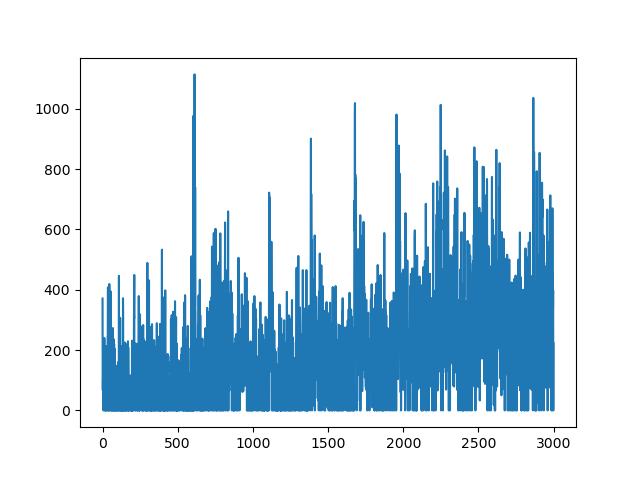

In [16]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

### DeepLabCut attempt!

In [17]:
sess.basepath = Path('/data2/Trace_FC/Recording_Rats/Django/2023_03_08_training')

In [18]:
sorted(sess.basepath.glob("**/*.h5"))

[PosixPath('/data2/Trace_FC/Recording_Rats/Django/2023_03_08_training/2_training/training/Django/gobears/2023_03_08/12_16_33/My_WebCam/Django_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5')]

In [19]:
import neuropy.io.dlcio as dlcio
DLC = dlcio.DLC(sess.basepath)

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Django/2023_03_08_training/2_training/training/Django/gobears/2023_03_08/12_16_33/My_WebCam/Django_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


In [20]:
DLC.bodyparts

Index(['back_middle', 'crown_middle', 'left_ear', 'neck_base', 'nose',
       'right_ear', 'tail_base', 'tail_end', 'tail_middle'],
      dtype='object', name='bodyparts')

<Axes: title={'center': 'Multiple bodyparts'}, xlabel='lcutoff = 0'>

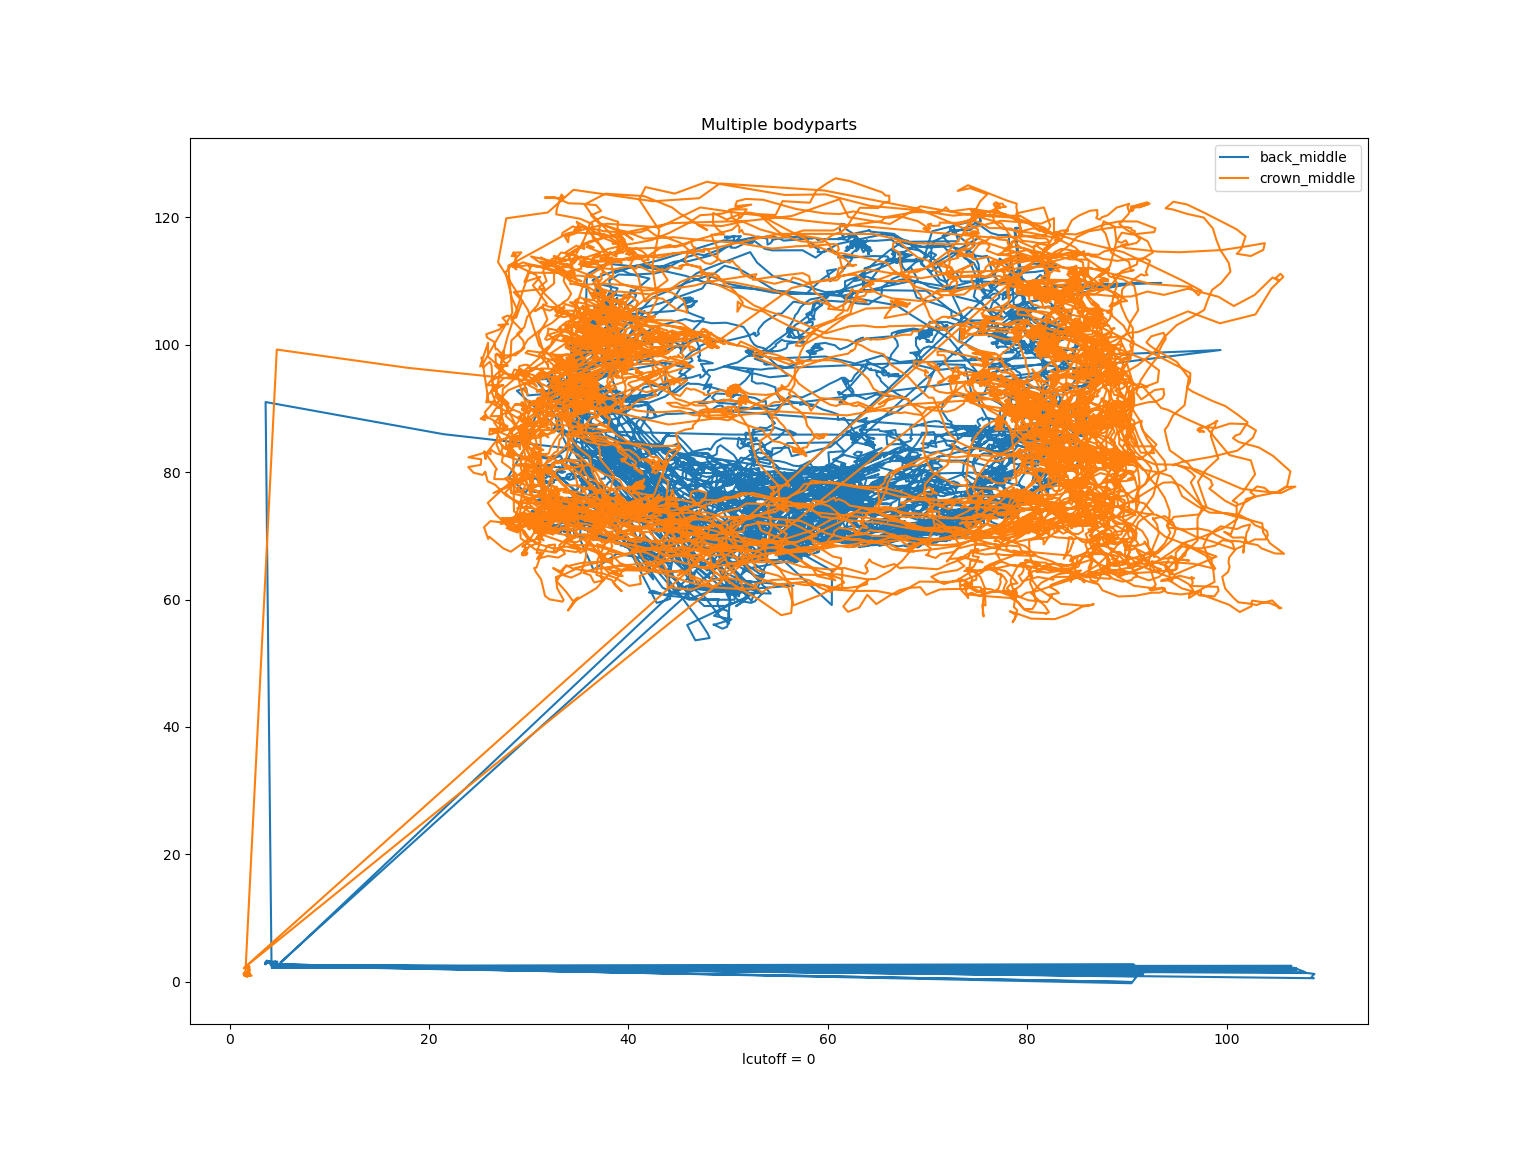

In [21]:
DLC.plot2d(bodyparts=['back_middle', 'crown_middle'])

# Wavelet Analysis

### Start with Theta

In [22]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

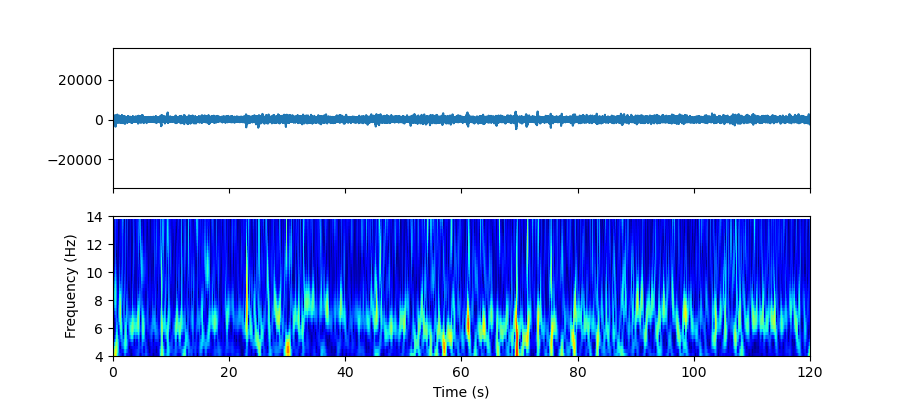

In [23]:
%matplotlib widget
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
theta_freq_lims = [4, 14]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [ 165  166  167 ... 1508 1509 1510] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

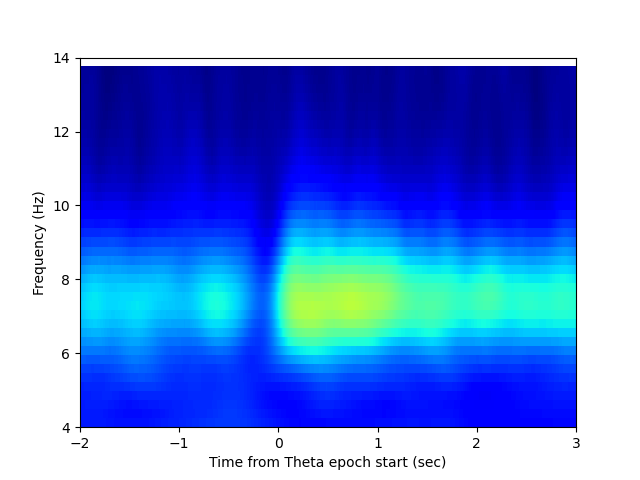

In [24]:
theta_buffer_sec = (2, 3)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [25]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

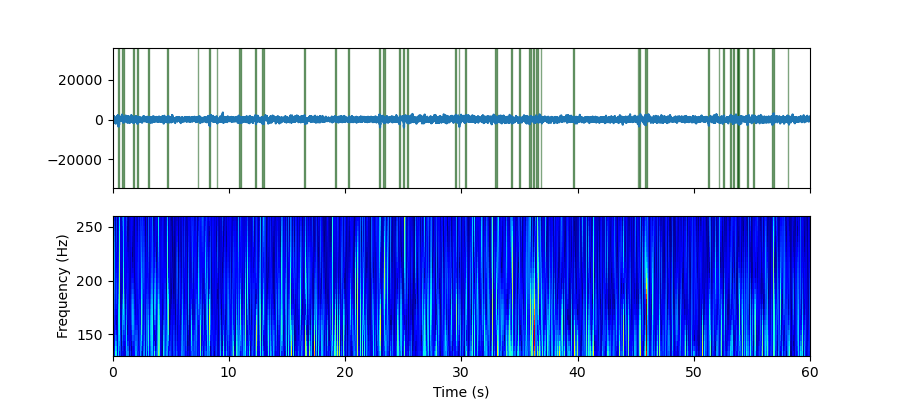

In [26]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

## Delta

In [27]:
delta_range = np.arange(0.5, 4.25, 0.1)
wv_delta = WaveletSg(signal.time_slice(channel_id=delta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=delta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

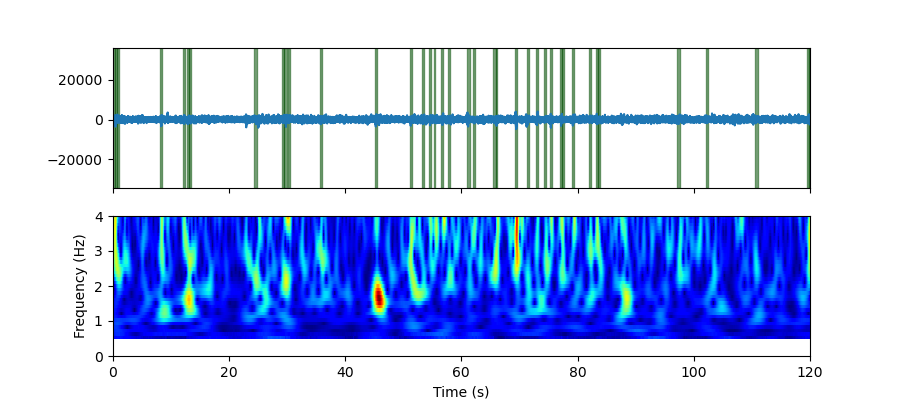

In [28]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
delta_freq_lims = [0.5, 4]

plot_signal_w_epochs(signal, delta_channel, delta_epochs, ax=ax[0])

plot_spectrogram(wv_delta, time_lims=time_to_plot, freq_lims=delta_freq_lims, ax=ax[1])

## Beta

In [29]:
# Run wavelet on beta range
beta_range = np.arange(12, 40, 1)  # How do I select these? 
wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=beta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

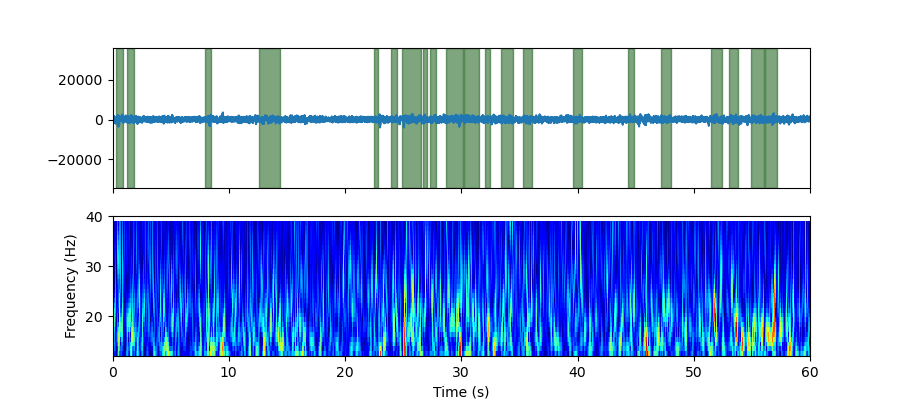

In [30]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
beta_freq_lims = [12, 40]

plot_signal_w_epochs(signal, beta_channel, beta_epochs, ax=ax[0])

plot_spectrogram(wv_beta, time_lims=time_to_plot, freq_lims=beta_freq_lims, ax=ax[1])

## Gamma

In [31]:
gamma_range = np.arange(40, 80, 1)
wv_gamma = WaveletSg(signal.time_slice(channel_id=gamma_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=gamma_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

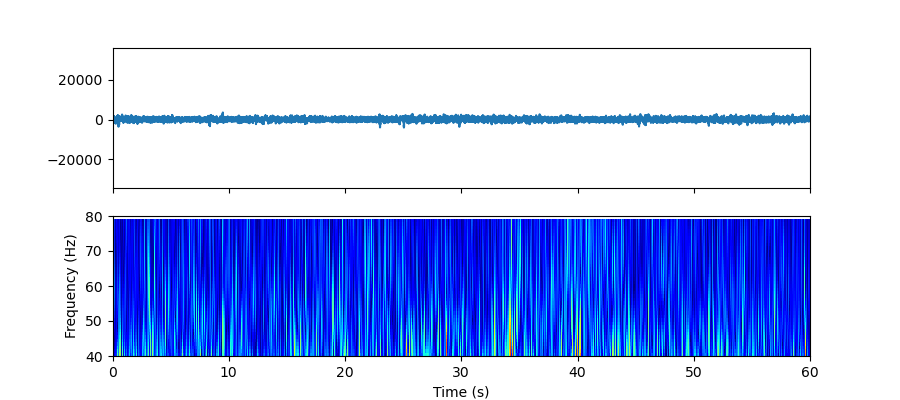

In [32]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
gamma_freq_lims = [40, 80]

plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])

plot_spectrogram(wv_gamma, time_lims=time_to_plot, freq_lims=gamma_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

Events [ 6491  6492  6493 ... 21249 21250 21251] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

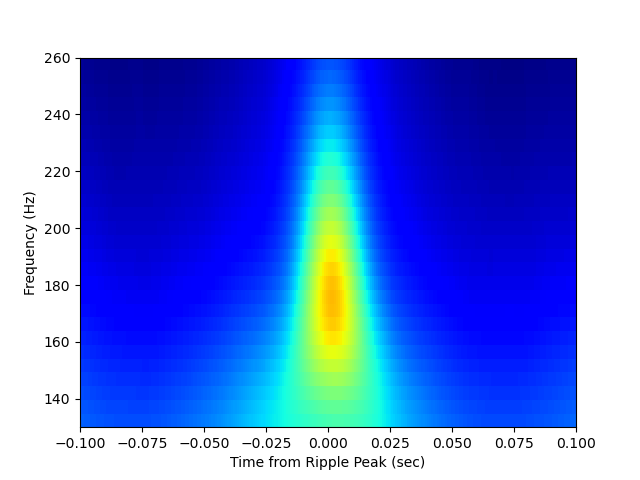

In [33]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-USV analyses

In [34]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


299 epochs
Snippet: 
          start         stop  Begin_Time   Freq_Min  Duration  Freq_Range  \
0  1099.471268  1099.554172  479.631519  37.931231  0.082915   25.781799   
1  1099.749291  1099.833033  479.909576  43.574457  0.083752   21.466391   
2  1100.246300  1100.312456  480.406645  41.472079  0.066164   19.585315   
3  1100.754614  1100.810833  480.915020  39.369700  0.056226   17.261634   
4  1101.555849  1101.651803  481.716352  34.722337  0.095966   20.359876   

   Score  Accept label  
0    1.0       1        
1    1.0       1        
2    1.0       1        
3    1.0       1        
4    1.0       1        

In [35]:
usv_epochs._epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0    1099.471268  1099.554172   479.631519  37.931231  0.082915   25.781799   
1    1099.749291  1099.833033   479.909576  43.574457  0.083752   21.466391   
2    1100.246300  1100.312456   480.406645  41.472079  0.066164   19.585315   
3    1100.754614  1100.810833   480.915020  39.369700  0.056226   17.261634   
4    1101.555849  1101.651803   481.716352  34.722337  0.095966   20.359876   
..           ...          ...          ...        ...       ...         ...   
294  2235.404953  2235.847877  1615.701863  16.277778  0.442977    7.666667   
295  2235.905064  2236.316906  1616.202034  17.375613  0.411892    7.474265   
296  2236.384538  2236.808221  1616.681566  15.579628  0.423734    9.516029   
297  2236.878080  2237.401800  1617.175167  17.166667  0.523783    7.597036   
298  2237.488905  2237.812043  1617.786066  16.464840  0.323177    6.639090   

     Score  Accept label  
0      1.0       1        
1      1.0       1        
2      1.0       1        
3      1.0       1        
4      1.0       1        
..     ...     ...   ...  
294    1.0       1        
295    1.0       1        
296    1.0       1        
297    1.0       1        
298    1.0       1        

[299 rows x 9 columns]

In [36]:
usv_epochs._epochs.Duration.mean()

0.47207773602988184

In [37]:
short_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Duration<0.1]
short_usv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0    1099.471268  1099.554172   479.631519  37.931231  0.082915   25.781799   
1    1099.749291  1099.833033   479.909576  43.574457  0.083752   21.466391   
2    1100.246300  1100.312456   480.406645  41.472079  0.066164   19.585315   
3    1100.754614  1100.810833   480.915020  39.369700  0.056226   17.261634   
4    1101.555849  1101.651803   481.716352  34.722337  0.095966   20.359876   
5    1101.935586  1102.009279   482.096134  38.263185  0.073702   11.286453   
7    1102.821995  1102.916624   482.982650  39.037746  0.094640   17.925543   
8    1103.475183  1103.565624   483.635916  35.496898  0.090452   18.478800   
10   1104.523633  1104.606538   484.684492  39.812306  0.082915   13.278180   
13   1106.879587  1106.977565   487.040730  34.943640  0.097990   22.572906   
14   1107.853183  1107.941112   488.014443  31.070838  0.087940   14.605998   
16   1111.415912  1111.514728   491.577601  35.054292  0.098827   22.572906   
17   1111.905385  1111.997501   492.067132  39.259049  0.092127   17.150982   
18   1112.356675  1112.433782   492.518476  36.492761  0.077117   17.482937   
19   1112.993565  1113.085681   493.155443  39.037746  0.092127   17.482937   
20   1113.310529  1113.345700   493.472445  36.271458  0.035176    7.302999   
23   1119.063607  1119.160748   499.226216  36.714064  0.097152   20.027921   
25   1121.953624  1122.049090   502.116581  34.390383  0.095477   20.249224   
26   1122.848967  1122.946107   503.012031  35.939504  0.097152   16.929679   
29   1126.929588  1127.026729   507.093143  37.488625  0.097152   15.159255   
31   1129.993112  1130.082716   510.157035  38.595140  0.089615   16.819028   
33   1133.529114  1133.626254   513.693463  35.054292  0.097152   19.032058   
34   1135.270660  1135.367801   515.435218  36.050155  0.097152   16.708376   
38   1140.387907  1140.478348   520.553081  37.377973  0.090452   18.368149   
39   1140.885497  1140.918156   521.050730  40.476215  0.032663    6.085832   
40   1142.089774  1142.185239   522.255152  40.586867  0.095477   11.175801   
44   1145.210271  1145.247117   525.376025  34.501034  0.036851   14.495346   
48   1154.833507  1154.907200   535.000419  37.820579  0.073702   11.950362   
50   1179.667203  1179.737546   559.837102  41.361427  0.070352    9.516029   
52   1204.448141  1204.545282   584.621022  37.820579  0.097152   11.618407   
53   1227.833937  1227.906793   608.009631  42.246639  0.072864   12.282316   
54   1234.567633  1234.656400   614.744137  38.816443  0.088777   14.716649   
55   1248.885006  1248.967911   629.063233  42.467942  0.082915    9.847983   
56   1249.996263  1250.090891   630.174623  37.267322  0.094640   11.950362   
57   1253.004854  1253.087758   633.183576  38.595140  0.082915   15.269907   
58   1253.776955  1253.850648   633.955770  41.250776  0.073702   10.511892   
59   1264.844560  1264.910716   645.024707  40.808170  0.066164    8.077559   
60   1265.269970  1265.343663   645.450168  39.922958  0.073702   10.290589   
61   1384.600672  1384.681064   764.795226  41.472079  0.080402   15.712513   
245  1956.367969  1956.461392  1336.631309  43.685109  0.093434   10.954498   
246  1956.585095  1956.652089  1336.848462  40.144261  0.067002   18.368149   
247  1956.884473  1956.971565  1337.147875  41.693382  0.087102   15.380558   

     Score  Accept label  
0      1.0       1        
1      1.0       1        
2      1.0       1        
3      1.0       1        
4      1.0       1        
5      1.0       1        
7      1.0       1        
8      1.0       1        
10     1.0       1        
13     1.0       1        
14     1.0       1        
16     1.0       1        
17     1.0       1        
18     1.0       1        
19     1.0       1        
20     1.0       1        
23     1.0       1        
25     1.0       1        
26     1.0       1        
29     1.0       1        
31     1.0       1        
33     1.0       1 

In [38]:
short_usv_epochs.Duration.mean()

0.08188471828614345

In [39]:
long_usv_epochs_filtered = usv_epochs._epochs[(usv_epochs._epochs.Duration>1)]
long_usv_epochs_filtered

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
63   1385.260982  1386.517366   765.455615  16.680464  1.256535   16.179912   
91   1403.709464  1404.817888   783.906317  18.162377  1.108557    8.523284   
104  1413.967150  1415.658965   794.165237  17.500000  1.692018    6.250000   
108  1425.230229  1426.648859   805.429671  18.293505  1.418800    7.212010   
113  1434.041186  1435.229080   814.241688  17.000000  1.188037    7.750000   
117  1441.835664  1442.894135   822.037104  17.250000  1.058598    6.625000   
133  1463.665195  1464.784280   843.869261  16.907446  1.119219    9.737332   
159  1493.249860  1494.475577   873.457485  17.682006  1.225865    9.516029   
171  1511.120634  1512.418403   891.330409  16.796794  1.297925   10.179938   
184  1529.694500  1531.024039   909.906509  15.358325  1.329699   11.618407   
196  1674.307424  1676.018782  1054.536831  19.633002  1.711564   16.534216   
217  1693.106838  1694.170141  1073.338507  17.128749  1.063431    7.302999   
230  1710.654193  1711.671573  1090.887973  16.851103  1.017502    7.080882   
258  1967.032274  1968.363733  1347.296897  14.915719  1.331619   15.269907   
266  2222.794628  2224.075923  1603.090020  20.226991  1.281449    7.243501   

        Score  Accept label  
63   1.000000       1        
91   1.000000       1        
104  0.518983       1        
108  1.000000       1        
113  0.600104       1        
117  0.627003       1        
133  1.000000       1        
159  1.000000       1        
171  1.000000       1        
184  1.000000       1        
196  1.000000       1        
217  1.000000       1        
230  1.000000       1        
258  1.000000       1        
266  1.000000       1

In [40]:
art_epochs

9 epochs
Snippet: 
        start       stop label
0   729.2412   729.9500  None
1  1097.3612  1099.2852  None
2  1382.4284  1383.8692  None
3  1672.6000  1674.1000  None
4  1952.6188  1954.1436  None

In [41]:
long_usv_epochs_filtered.Duration.mean()

1.2733879162545918

In [42]:
usv_epochs.n_epochs

299

In [43]:
long_usv_epochs_filtered.shape

(15, 9)

In [44]:
short_usv_epochs.shape

(42, 9)

In [45]:
freq_thresh = 30
low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
low_usvs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
63   1385.260982  1386.517366   765.455615  16.680464  1.256535   16.179912   
64   1386.595436  1387.111989   766.790230  16.208057  0.516615    9.566225   
65   1387.175823  1387.671112   767.370687  14.672737  0.495348   10.983444   
66   1387.730032  1387.919642   767.924963  16.680464  0.189632    8.030905   
67   1387.974406  1388.446657   768.169366  16.680464  0.472308    8.857616   
..           ...          ...          ...        ...       ...         ...   
294  2235.404953  2235.847877  1615.701863  16.277778  0.442977    7.666667   
295  2235.905064  2236.316906  1616.202034  17.375613  0.411892    7.474265   
296  2236.384538  2236.808221  1616.681566  15.579628  0.423734    9.516029   
297  2236.878080  2237.401800  1617.175167  17.166667  0.523783    7.597036   
298  2237.488905  2237.812043  1617.786066  16.464840  0.323177    6.639090   

     Score  Accept label  
63     1.0       1        
64     1.0       1        
65     1.0       1        
66     1.0       1        
67     1.0       1        
..     ...     ...   ...  
294    1.0       1        
295    1.0       1        
296    1.0       1        
297    1.0       1        
298    1.0       1        

[231 rows x 9 columns]

In [46]:
high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > freq_thresh]
high_usvs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0    1099.471268  1099.554172   479.631519  37.931231  0.082915   25.781799   
1    1099.749291  1099.833033   479.909576  43.574457  0.083752   21.466391   
2    1100.246300  1100.312456   480.406645  41.472079  0.066164   19.585315   
3    1100.754614  1100.810833   480.915020  39.369700  0.056226   17.261634   
4    1101.555849  1101.651803   481.716352  34.722337  0.095966   20.359876   
..           ...          ...          ...        ...       ...         ...   
215  1686.915891  1687.044853  1067.146815  39.922958  0.128978   13.167528   
244  1956.043284  1956.159686  1336.306586  41.804033  0.116415   13.499483   
245  1956.367969  1956.461392  1336.631309  43.685109  0.093434   10.954498   
246  1956.585095  1956.652089  1336.848462  40.144261  0.067002   18.368149   
247  1956.884473  1956.971565  1337.147875  41.693382  0.087102   15.380558   

     Score  Accept label  
0      1.0       1        
1      1.0       1        
2      1.0       1        
3      1.0       1        
4      1.0       1        
..     ...     ...   ...  
215    1.0       1        
244    1.0       1        
245    1.0       1        
246    1.0       1        
247    1.0       1        

[68 rows x 9 columns]

In [47]:
high_usvs.Duration.mean()

0.09594978387788528

## Theta mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start(sec)')

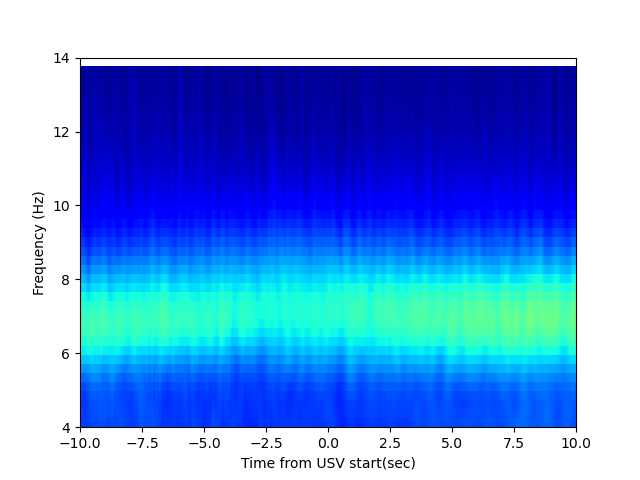

In [48]:
# Example code to plot theta at USV starts
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV stop(sec)')

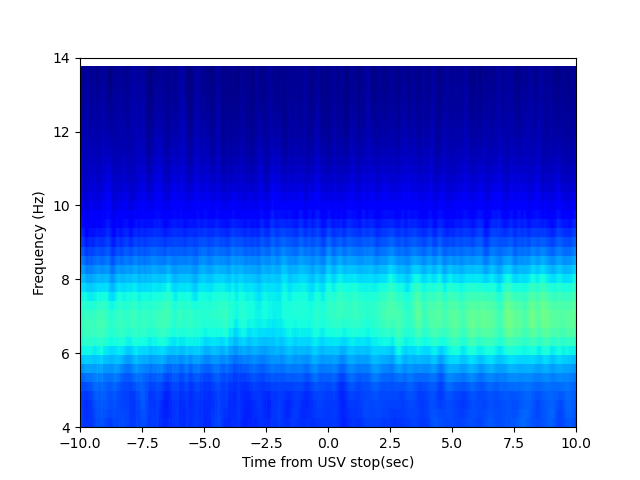

In [49]:
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['stop'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV stop(sec)')

In [50]:
art_epochs

9 epochs
Snippet: 
        start       stop label
0   729.2412   729.9500  None
1  1097.3612  1099.2852  None
2  1382.4284  1383.8692  None
3  1672.6000  1674.1000  None
4  1952.6188  1954.1436  None

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start (sec)')

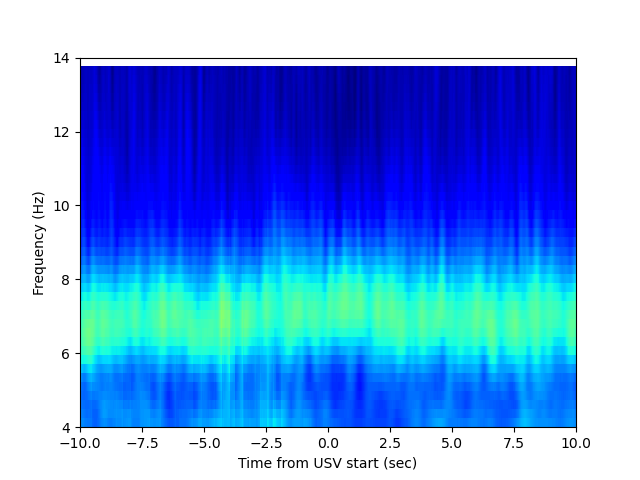

In [51]:
# High USV
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(high_usvs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start (sec)')

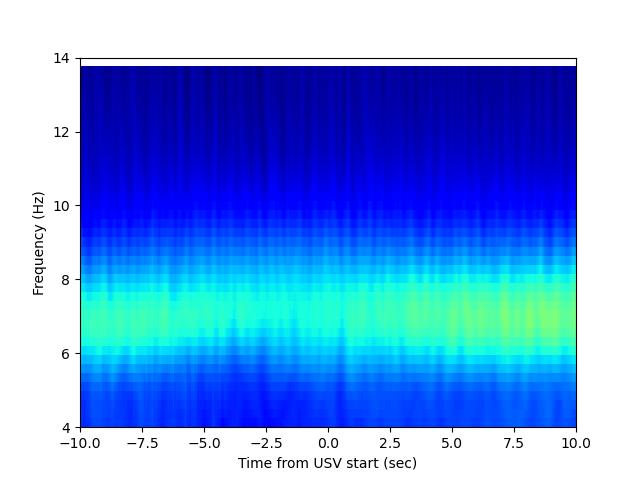

In [52]:
# Low USV
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(low_usvs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start (sec)')

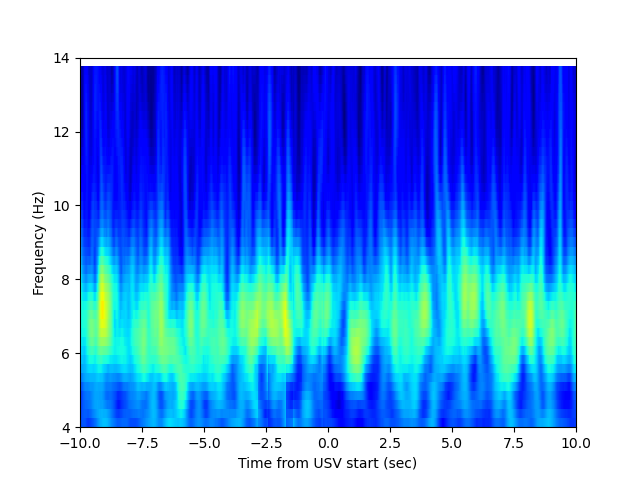

In [53]:
# Long USV
#exclude noise
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start (sec)')

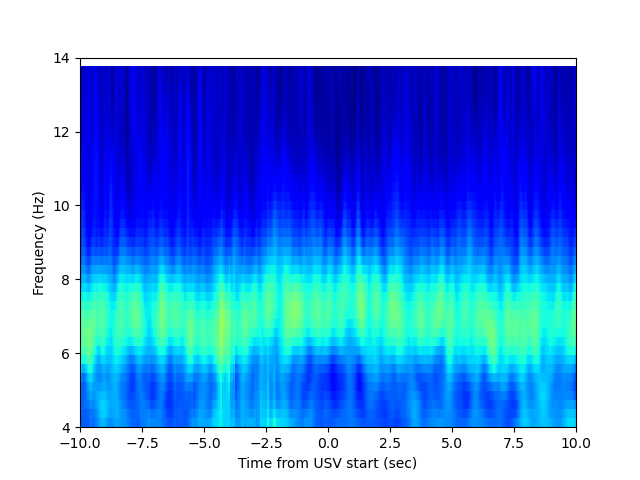

In [54]:
# Short USV
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Ripple mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

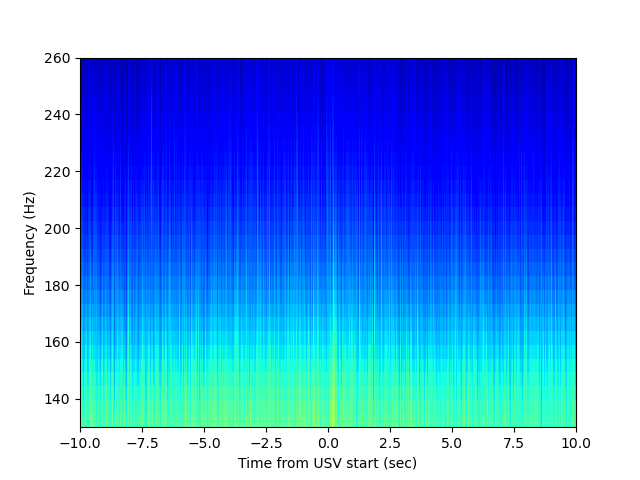

In [55]:
# All
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 1.0, 'High Freq. USVs, mean duration=0.096, std=0.024')

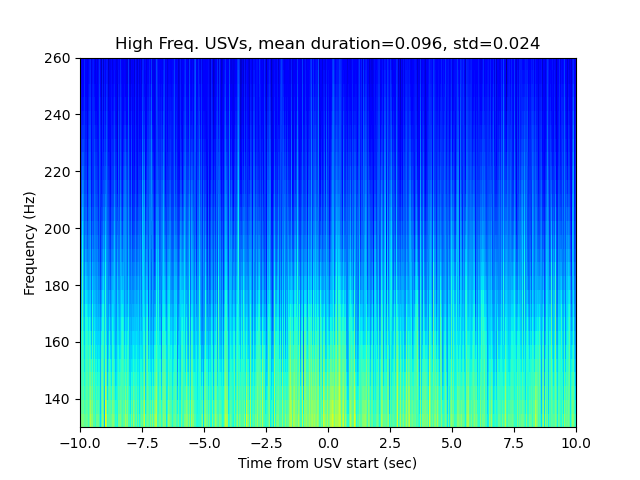

In [56]:
# High USVs
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(high_usvs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')
ax.set_title(f"High Freq. USVs, mean duration={high_usvs.Duration.mean():.3f}, std={high_usvs.Duration.std():.3f}")

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 1.0, 'Low Freq. USVs, mean duration=0.583, std=0.268')

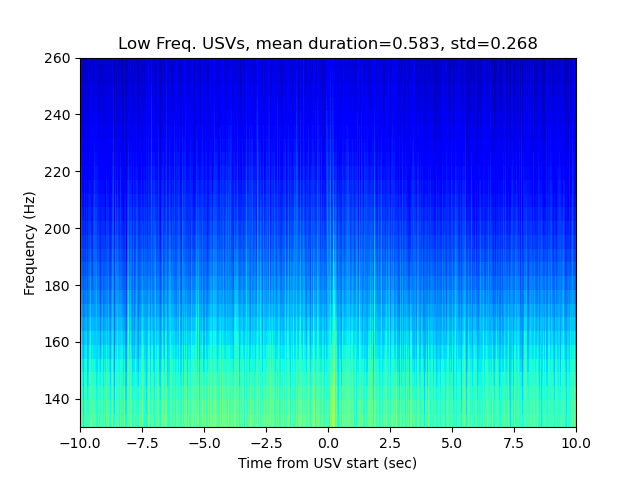

In [57]:
# Low USVs
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(low_usvs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')
ax.set_title(f"Low Freq. USVs, mean duration={low_usvs.Duration.mean():.3f}, std={low_usvs.Duration.std():.3f}")

/data/GitHub/NeuroPy/neuropy/plotting/signals.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

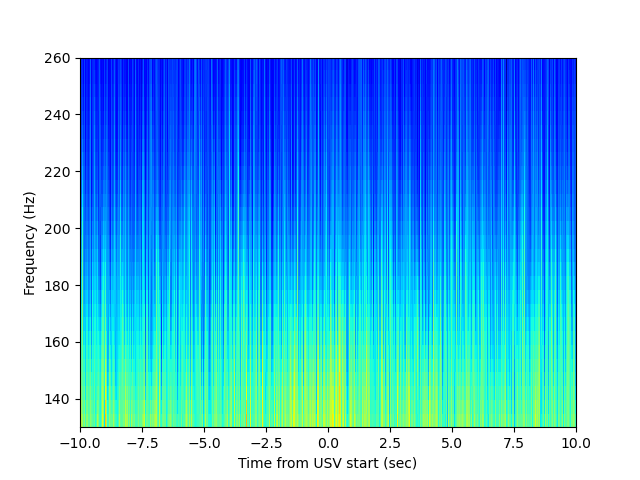

In [58]:
# short USV
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start (sec)')

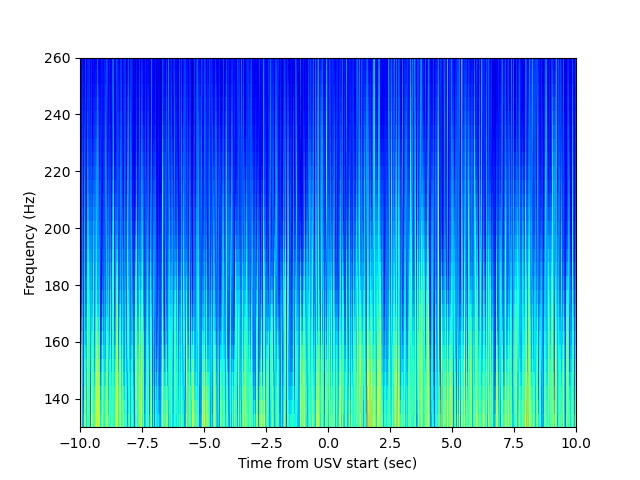

In [59]:
#long USV
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(0…

Text(0.5, 0, 'Time from USV start(sec)')

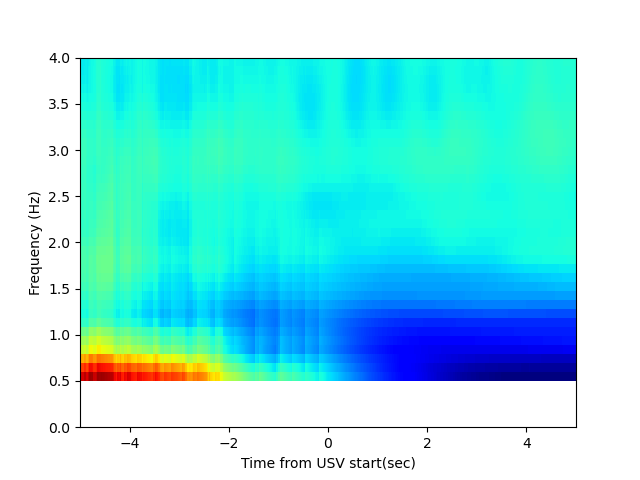

In [60]:
#Delta
usv_buffer_sec = (5, 5)
wv_delta_mean = wv_delta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from USV start(sec)')

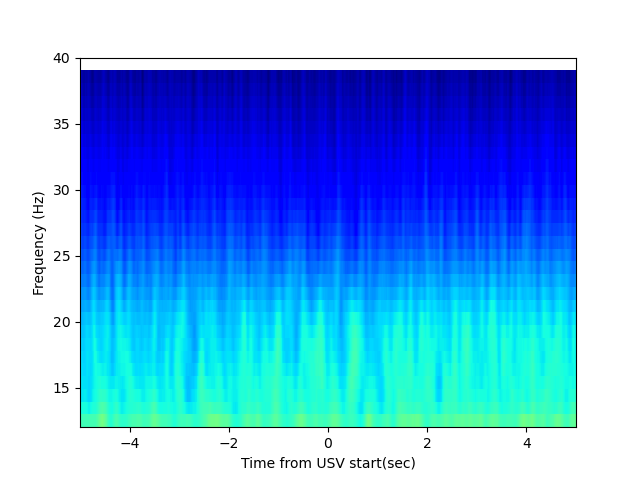

In [61]:
#Beta
usv_buffer_sec = (5, 5)
wv_beta_mean = wv_beta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(4…

Text(0.5, 0, 'Time from USV start(sec)')

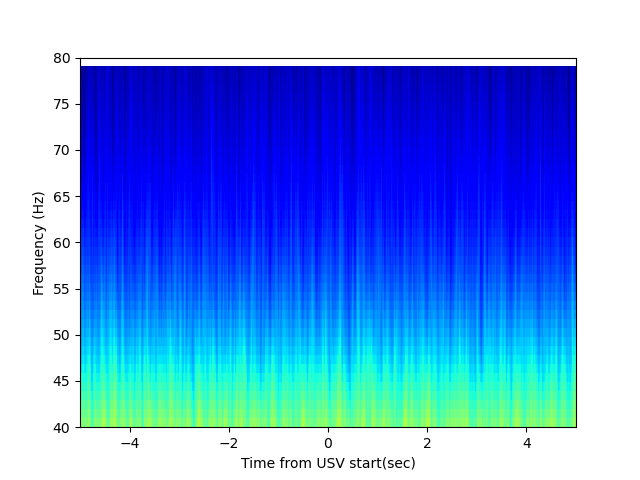

In [62]:
#Gamma
usv_buffer_sec = (5, 5)
wv_gamma_mean = wv_gamma.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_gamma_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=gamma_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

## Save notebook to working directory

In [63]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Animal_files/Training notebooks/USV_Spectral_Analysis(Django).ipynb saved to /data2/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_USV_Spectral_Analysis(Django).ipynb
